In [1]:
import pandas as pd
import os

# Define the path to the dataset folder
data_path = "/kaggle/input/rainfall-data-from-1901-to-2017-for-india"

# List the files in the directory
files = os.listdir(data_path)
print("Files in dataset:", files)

# Load the CSV file (update the filename if necessary)
csv_file = [f for f in files if f.endswith('.csv')][0]  # Auto-detect CSV file
df = pd.read_csv(os.path.join(data_path, csv_file))

# Display the first few rows
print(df)


Files in dataset: ['Rainfall_Data_LL.csv']
         Name                SUBDIVISION  YEAR   JAN    FEB   MAR    APR  \
0        ROW1  Andaman & Nicobar Islands  1901  49.2   87.1  29.2    2.3   
1        ROW2  Andaman & Nicobar Islands  1902   0.0  159.8  12.2    0.0   
2        ROW3  Andaman & Nicobar Islands  1903  12.7  144.0   0.0    1.0   
3        ROW4  Andaman & Nicobar Islands  1904   9.4   14.7   0.0  202.4   
4        ROW5  Andaman & Nicobar Islands  1905   1.3    0.0   3.3   26.9   
...       ...                        ...   ...   ...    ...   ...    ...   
4182  ROW4183                Lakshadweep  2012  19.2    0.1   1.6   76.8   
4183  ROW4184                Lakshadweep  2013  26.2   34.4  37.5    5.3   
4184  ROW4185                Lakshadweep  2014  53.2   16.1   4.4   14.9   
4185  ROW4186                Lakshadweep  2015   2.2    0.5   3.7   87.1   
4186  ROW4187                Lakshadweep  2016  59.6   12.1   3.2    2.6   

        MAY    JUN    JUL  ...    OCT    NOV

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


Missing Values:
 Name              0
SUBDIVISION       0
YEAR              0
JAN               0
FEB               0
MAR               0
APR               0
MAY               0
JUN               0
JUL               0
AUG               0
SEP               0
OCT               0
NOV               0
DEC               0
ANNUAL            0
Jan-Feb           0
Mar-May           0
June-September    0
Oct-Dec           0
Latitude          0
Longitude         0
dtype: int64
              YEAR          JAN          FEB          MAR          APR  \
count  4187.000000  4187.000000  4187.000000  4187.000000  4187.000000   
mean   1959.206831    18.937772    21.604374    27.395503    43.081712   
std      33.709294    33.780997    35.721764    46.886429    68.123572   
min    1901.000000     0.000000     0.000000     0.000000     0.000000   
25%    1930.000000     0.600000     0.500000     1.000000     3.000000   
50%    1959.000000     6.000000     6.500000     7.900000    15.500000   
75%    1988.

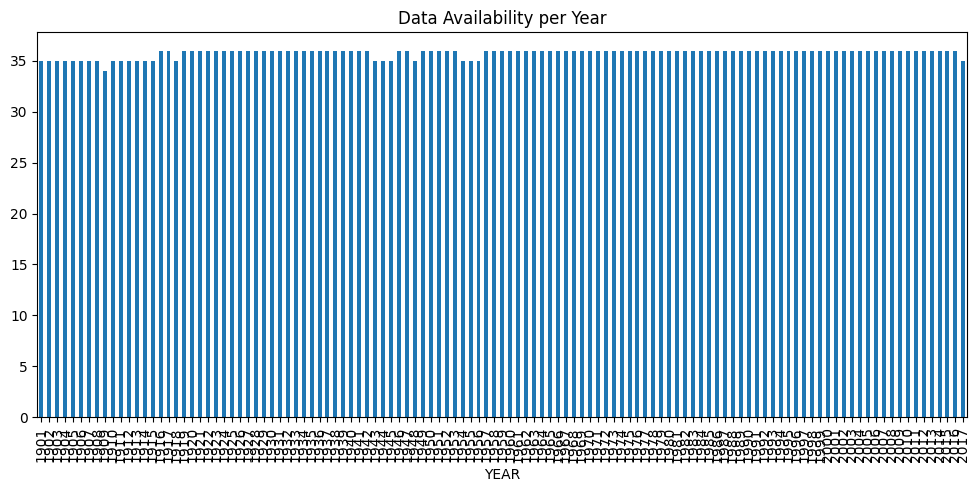

In [3]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Display basic statistics
print(df.describe())

# Count missing values per year
df.groupby("YEAR").count().iloc[:, 0].plot(
    kind="bar", figsize=(12, 5), title="Data Availability per Year"
)
plt.show()


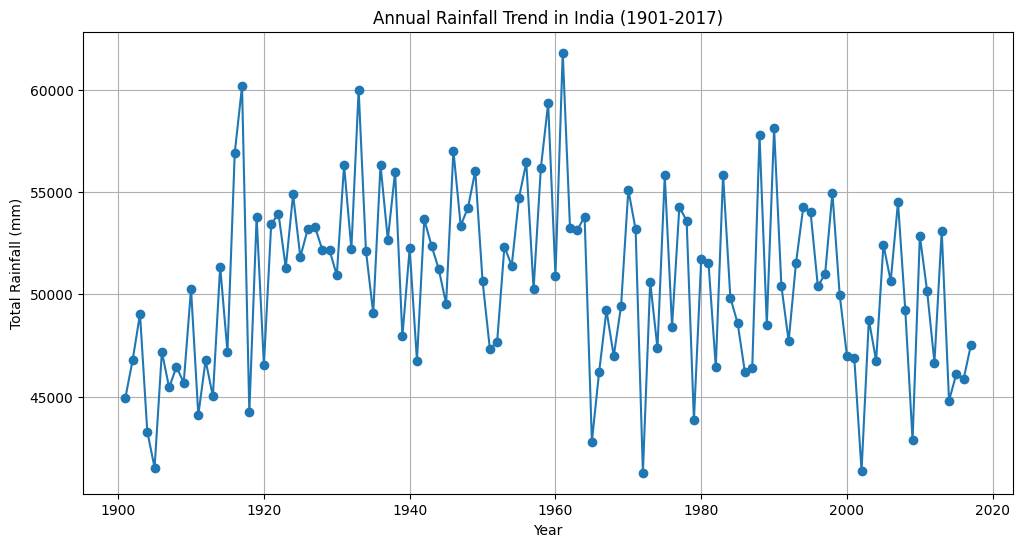

In [4]:
plt.figure(figsize=(12,6))
df.groupby('YEAR').sum()['ANNUAL'].plot(marker='o', linestyle='-')
plt.title("Annual Rainfall Trend in India (1901-2017)")
plt.xlabel("Year")
plt.ylabel("Total Rainfall (mm)")
plt.grid(True)
plt.show()


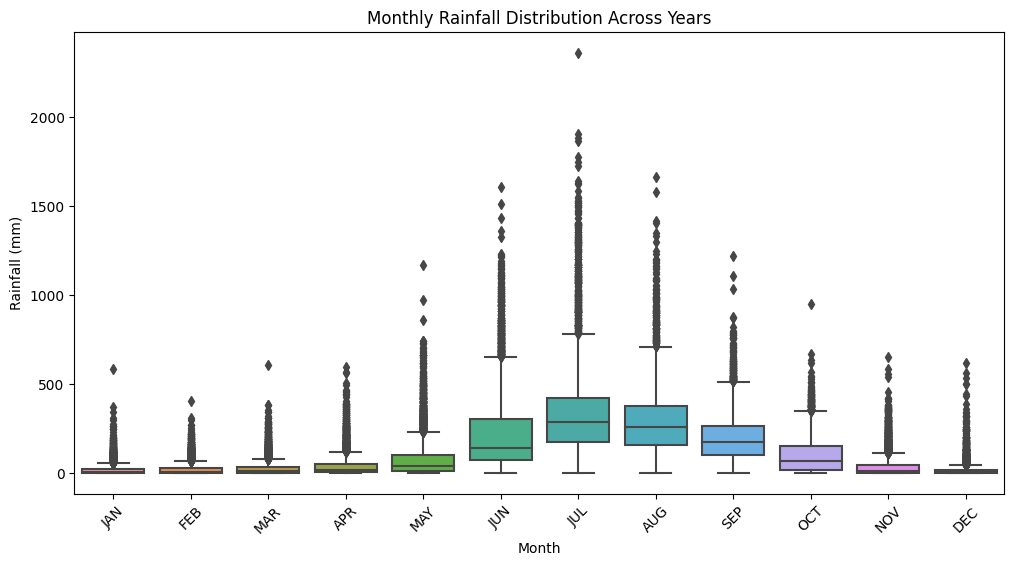

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[[ 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                      'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']])
plt.title("Monthly Rainfall Distribution Across Years")
plt.xlabel("Month")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.show()


**This visualization directly relates with rainy season in India.**

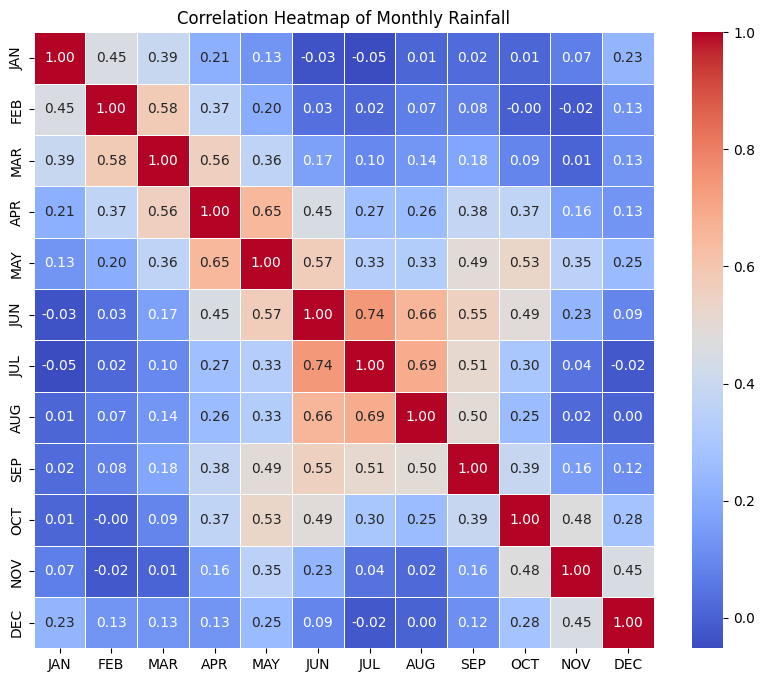

In [6]:
plt.figure(figsize=(10, 8))
corr_matrix = df[[ 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                   'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Monthly Rainfall")
plt.show()


**Month wise correlations are not very significant. How ever a seasonal trend can be explored.**

In [7]:

def plot_rainfall_heatmap(df, state_name):
    state_df = df[df['SUBDIVISION'] == state_name]
    if state_df.empty:
        print(f"No data found for state: {state_name}")
        return

    # Define the correct order of months
    month_order = ['DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL', 
                   'JUN', 'MAY', 'APR', 'MAR', 'FEB', 'JAN']


    # Melt the dataframe to long format
    pivot_df = state_df.melt(id_vars=['YEAR'], value_vars=month_order, 
                             var_name='Month', value_name='Rainfall')
    
    # Convert Month to categorical type to enforce order
    pivot_df['Month'] = pd.Categorical(pivot_df['Month'], categories=month_order, ordered=True)

    # Pivot again for heatmap
    pivot_df = pivot_df.pivot(index='Month', columns='YEAR', values='Rainfall')

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, cmap='Blues', linewidths=0.5)

    plt.title(f"Monthly Rainfall Heatmap for {state_name}")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.show()

**Time Series visualisation for state wise rainfall data can help us explore seasonal trends.**

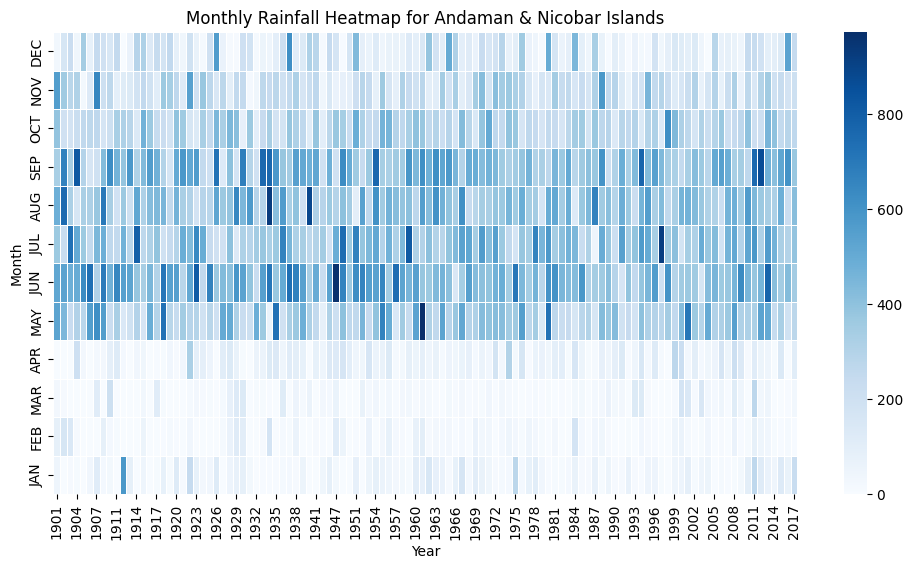

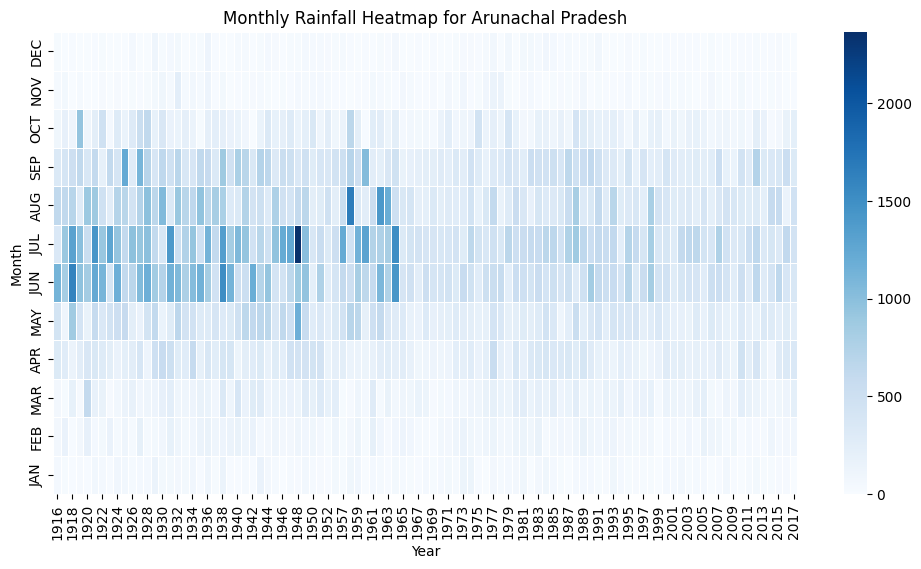

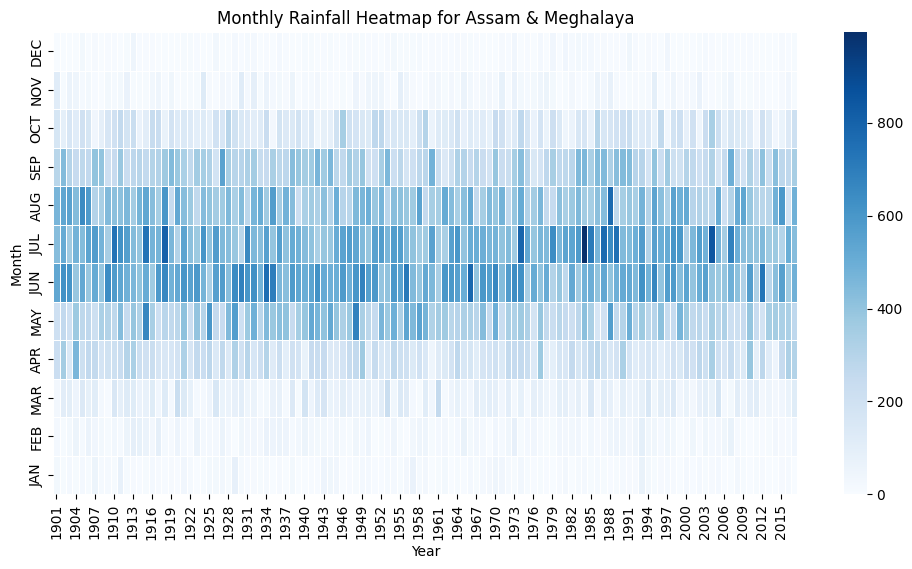

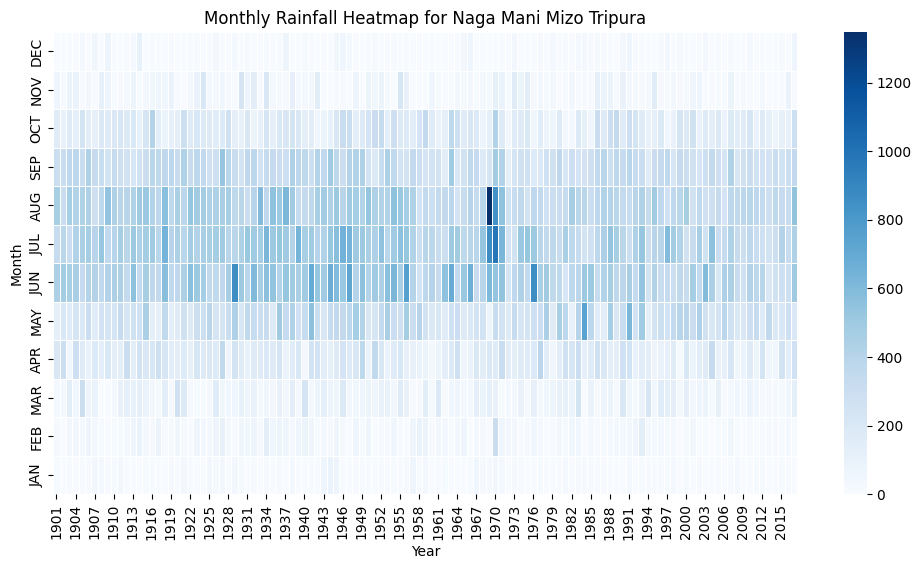

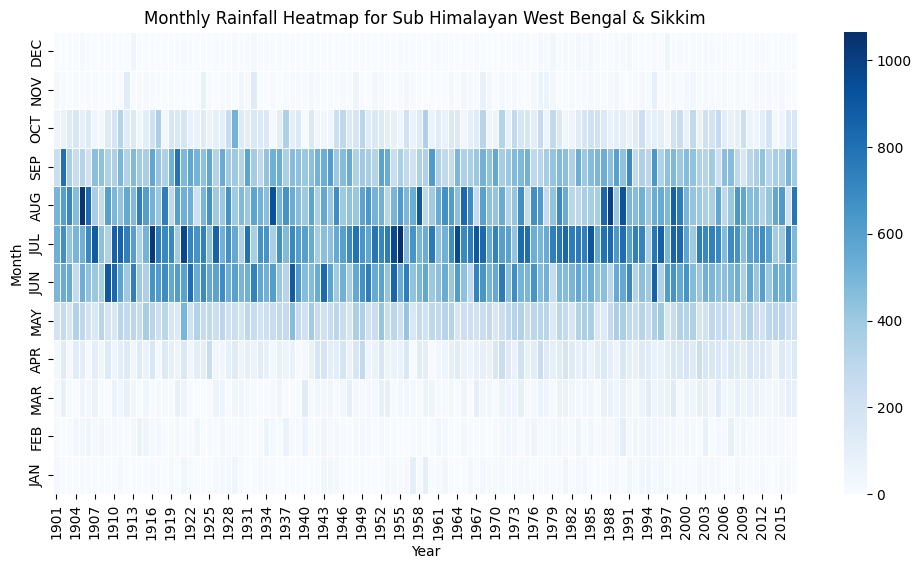

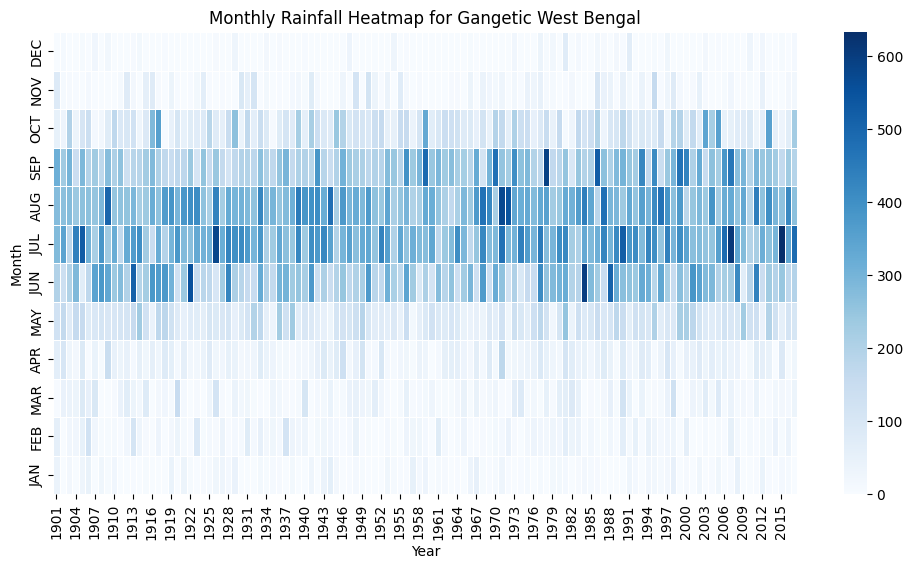

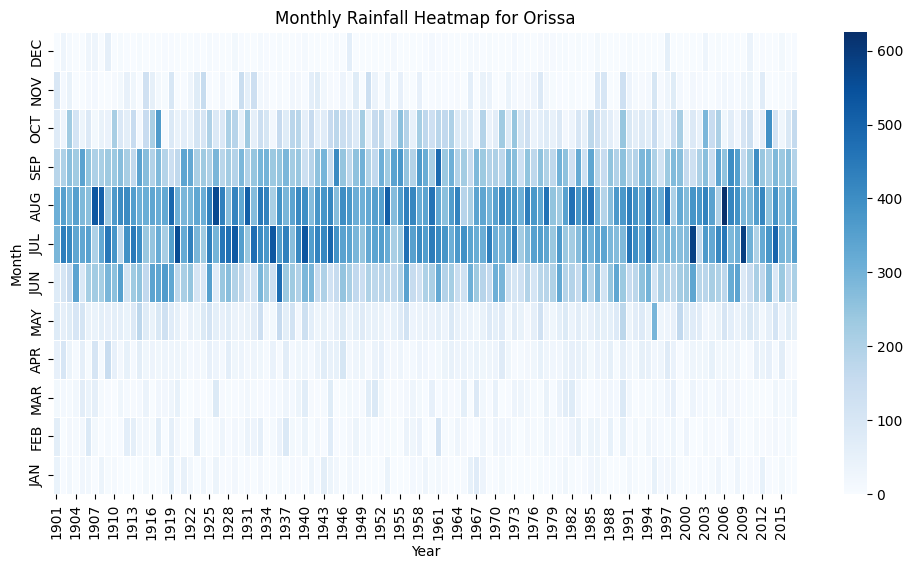

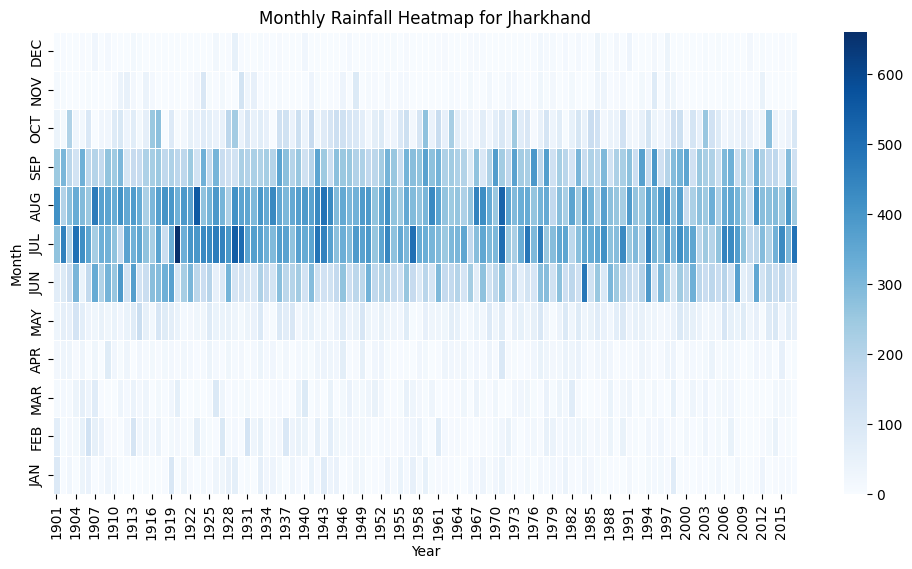

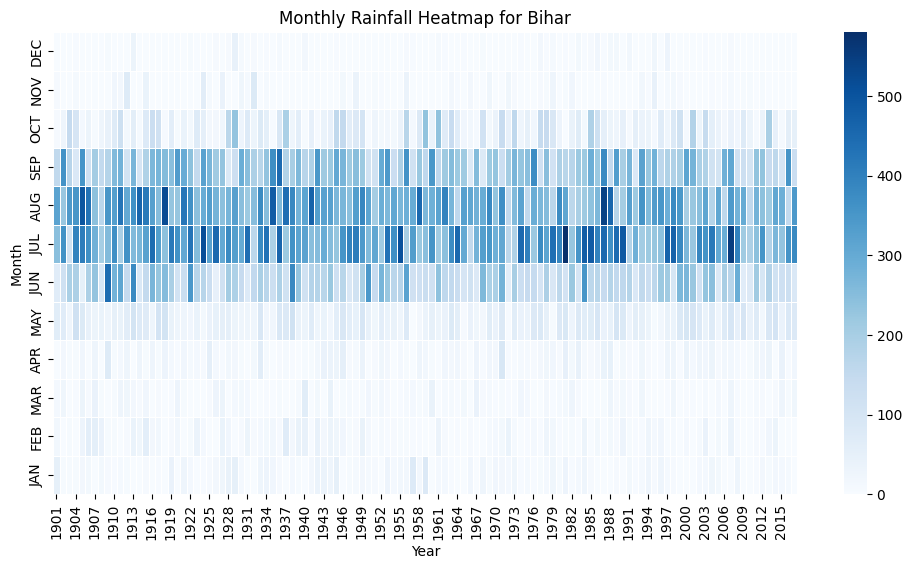

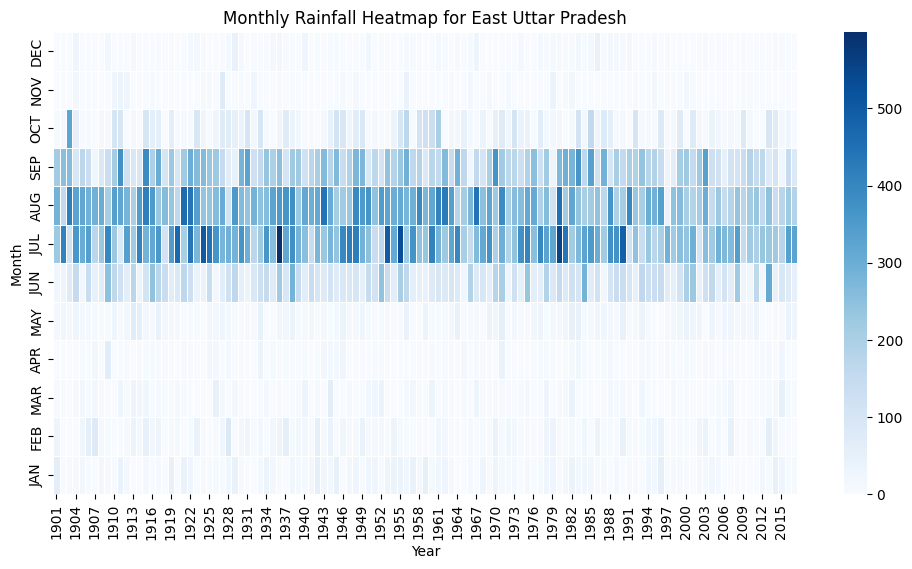

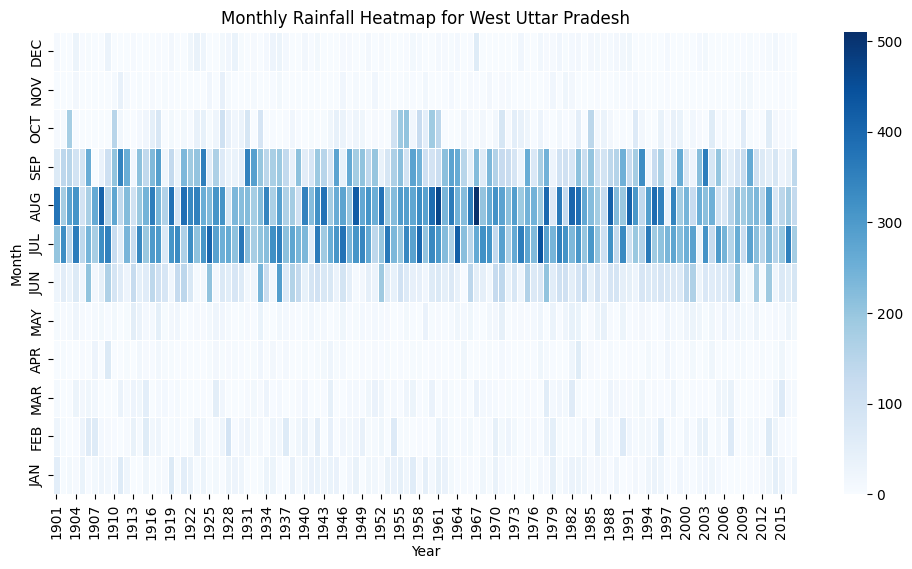

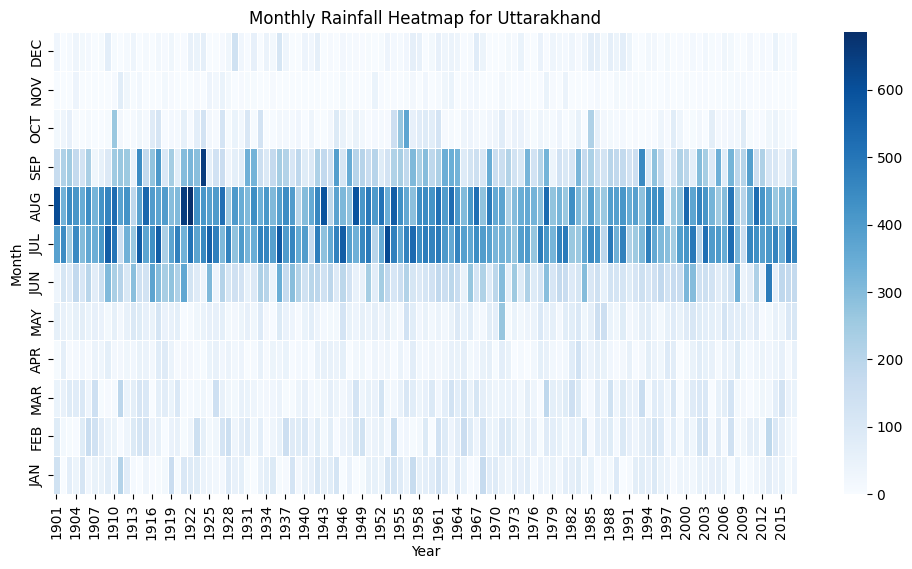

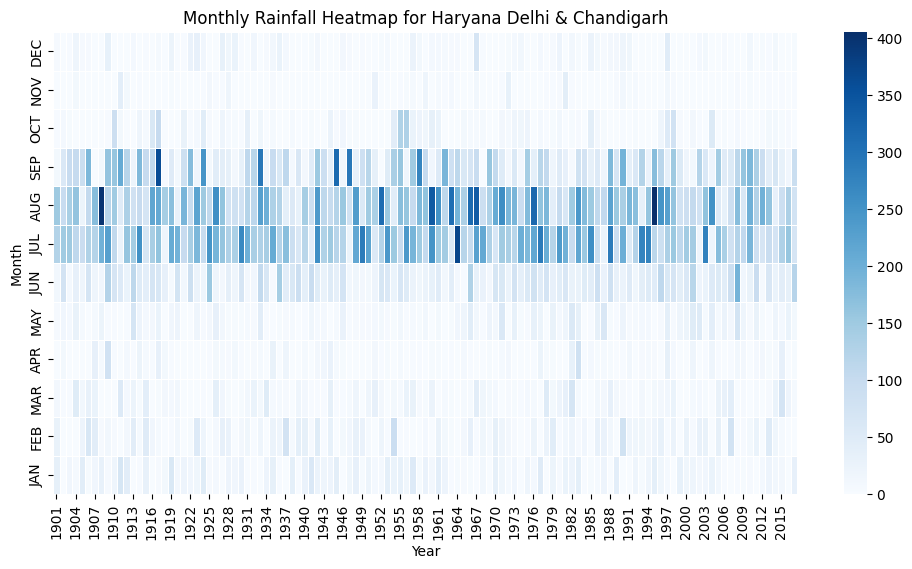

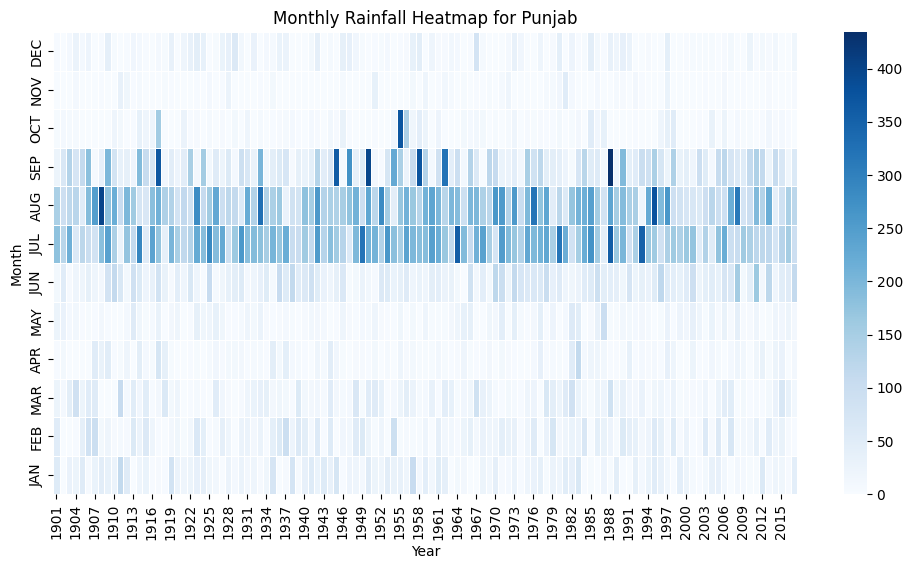

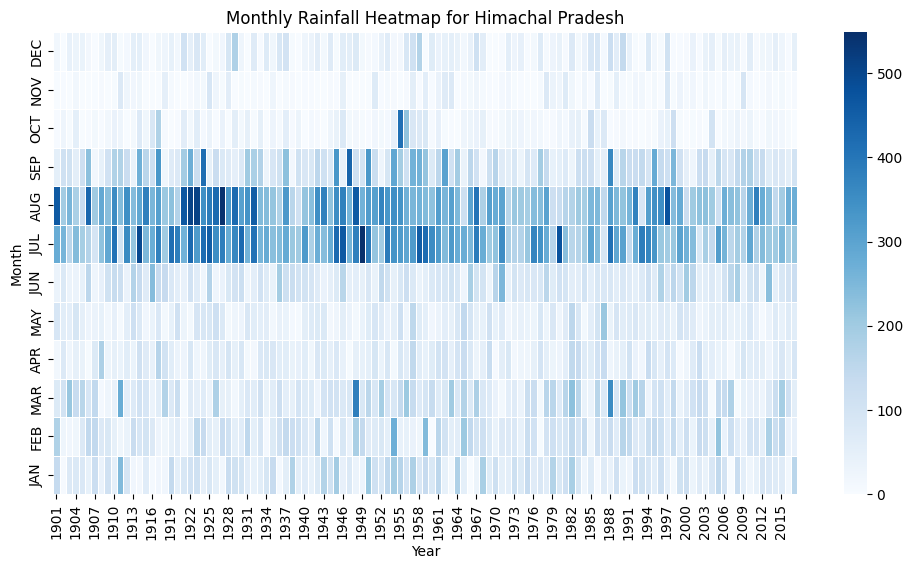

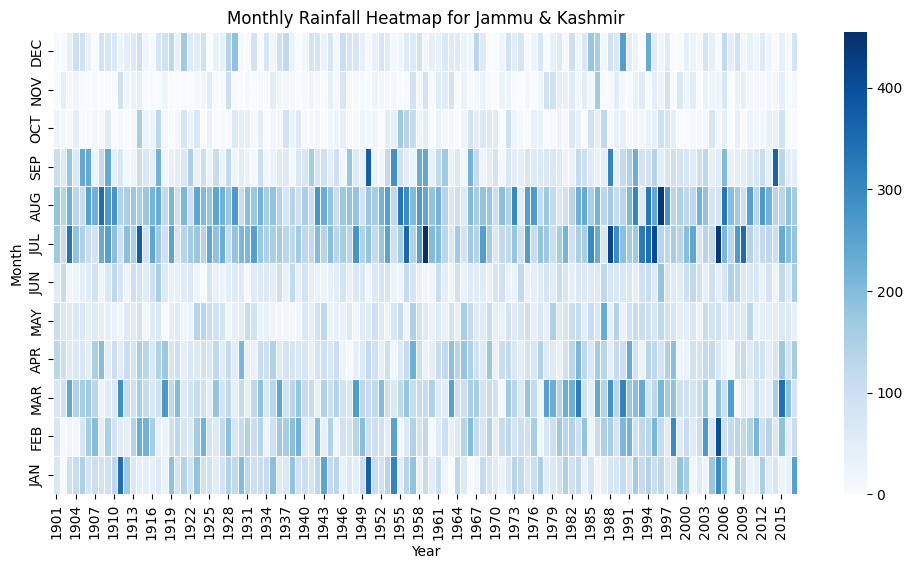

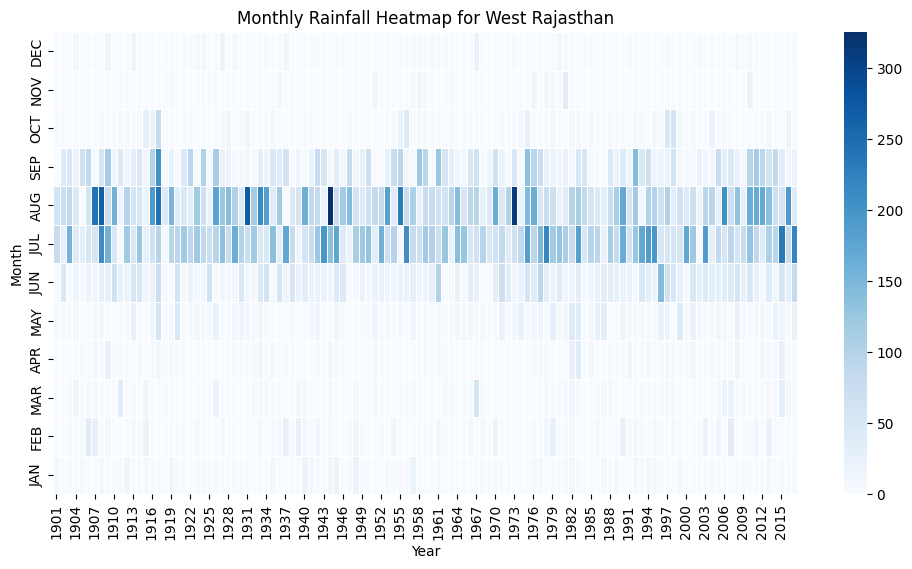

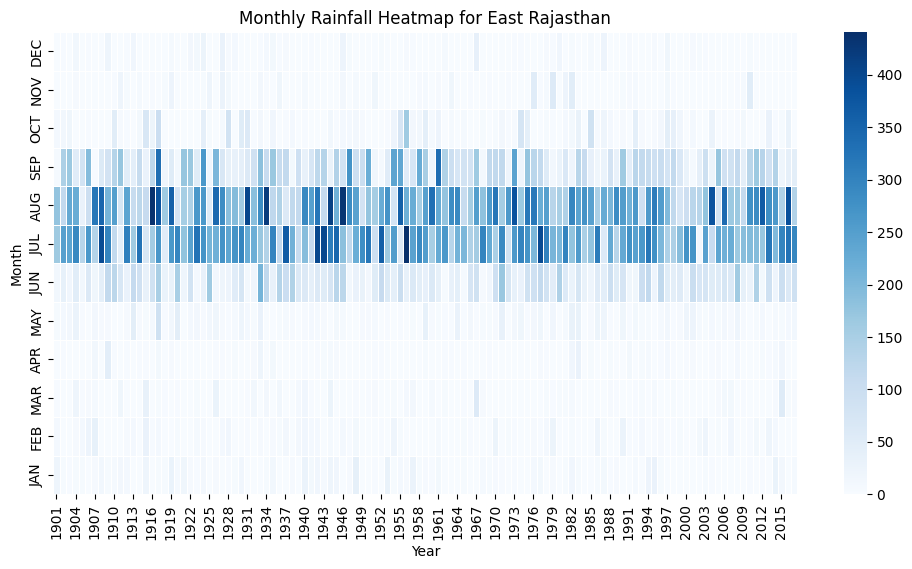

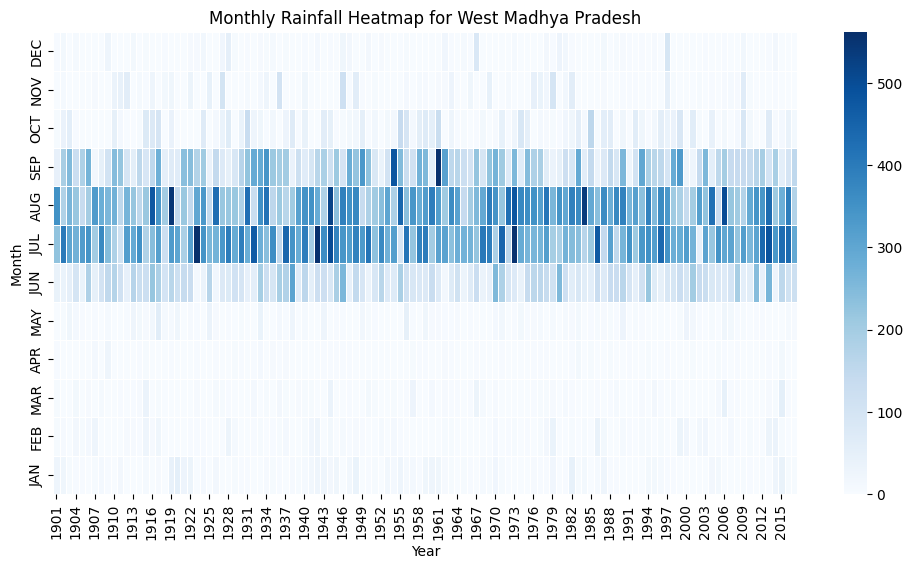

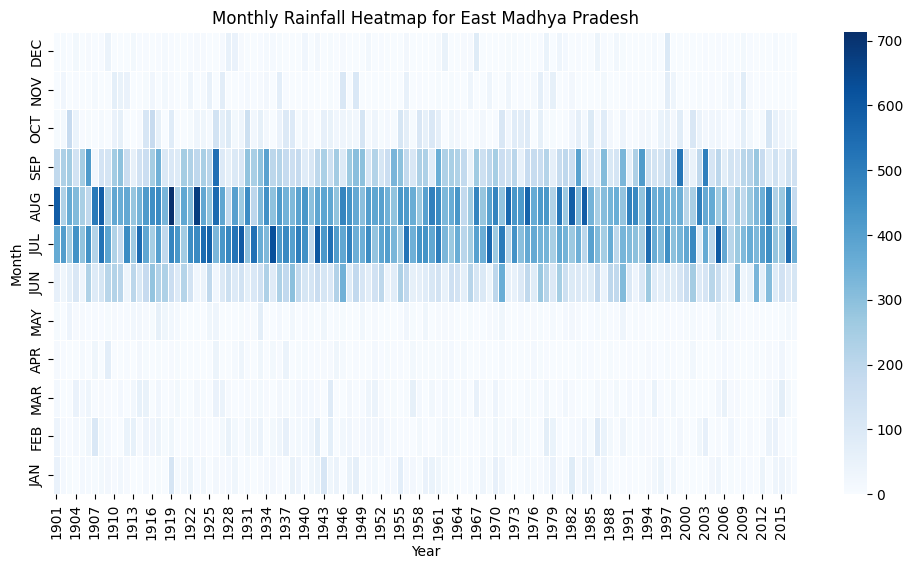

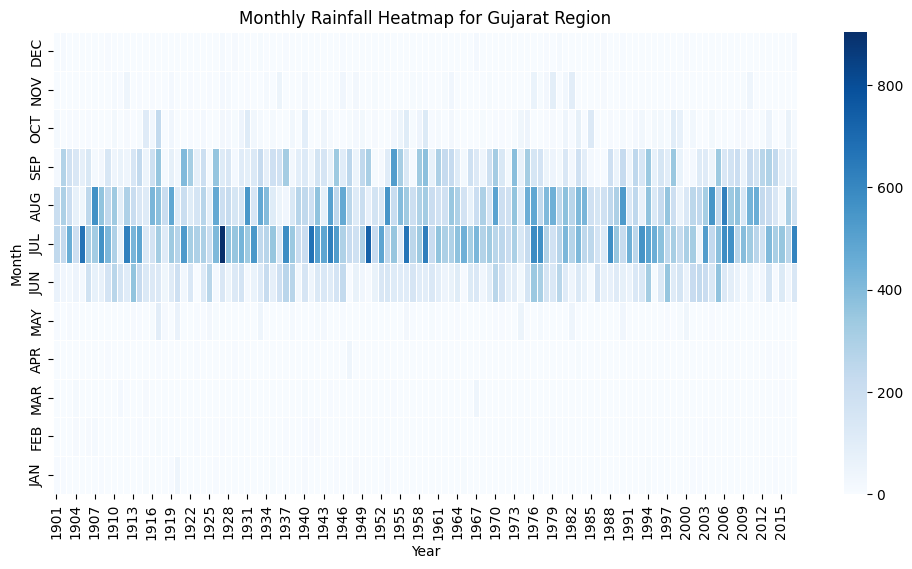

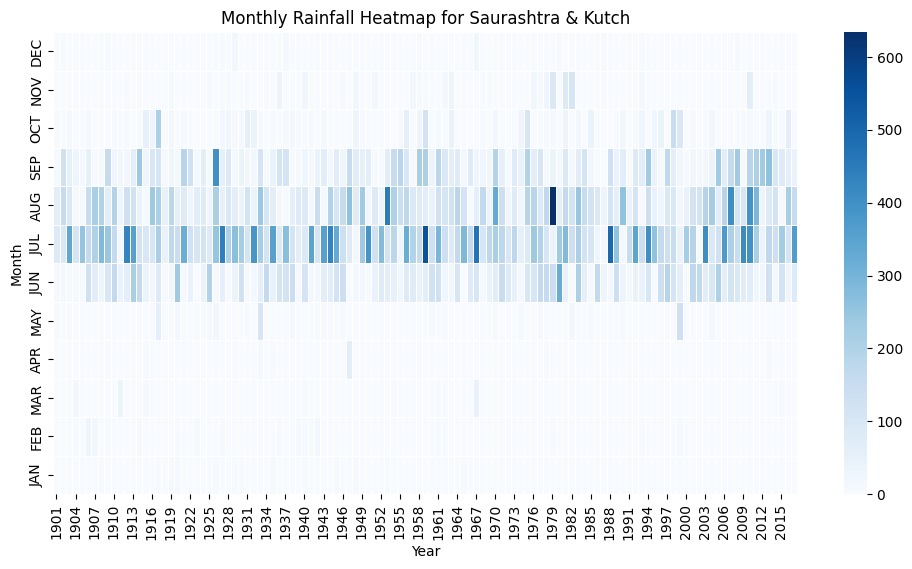

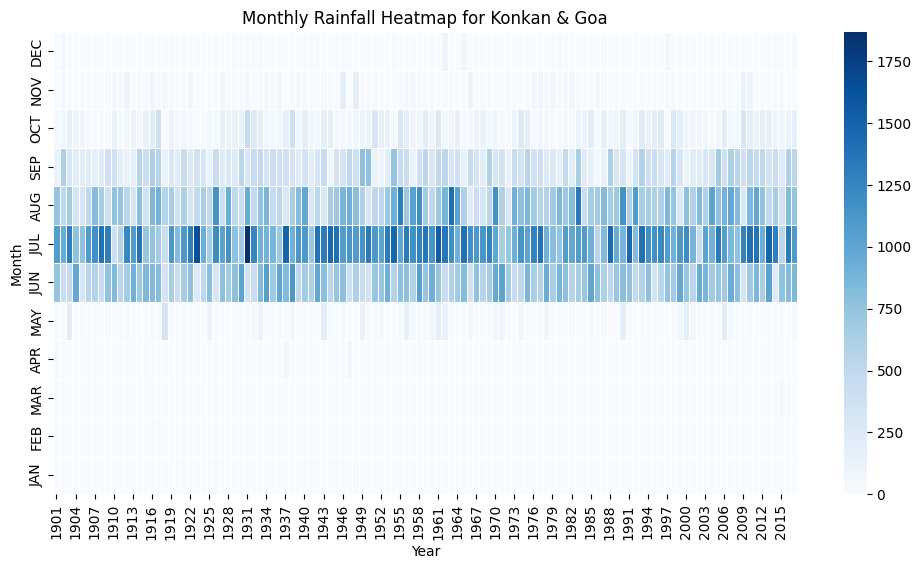

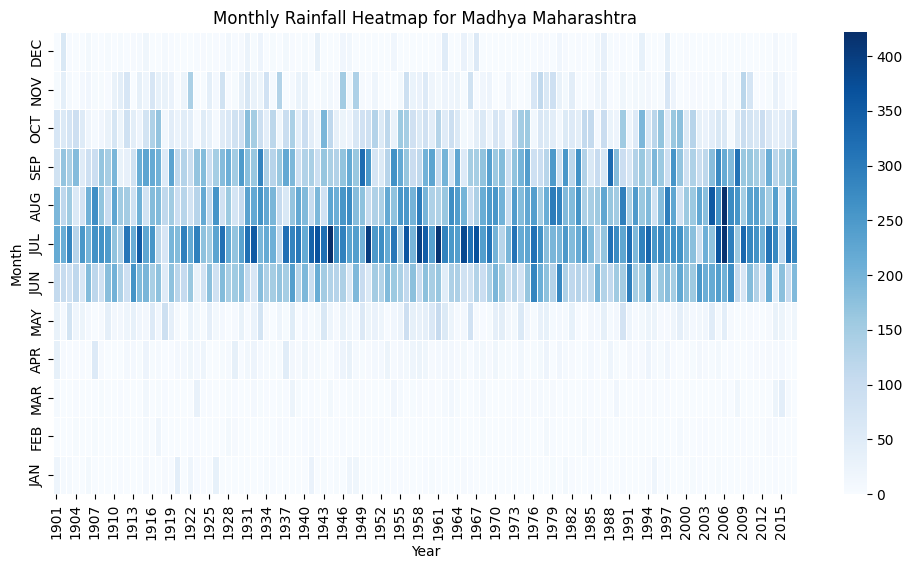

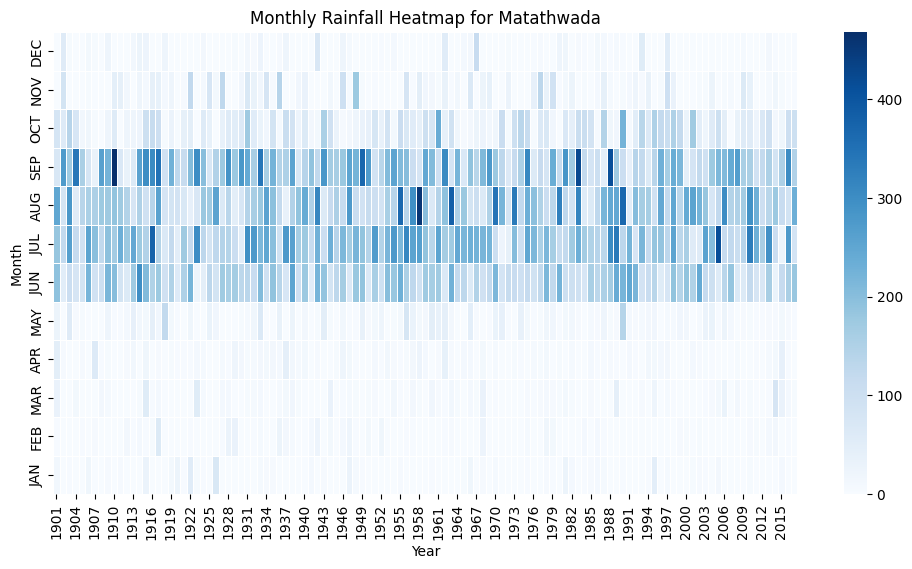

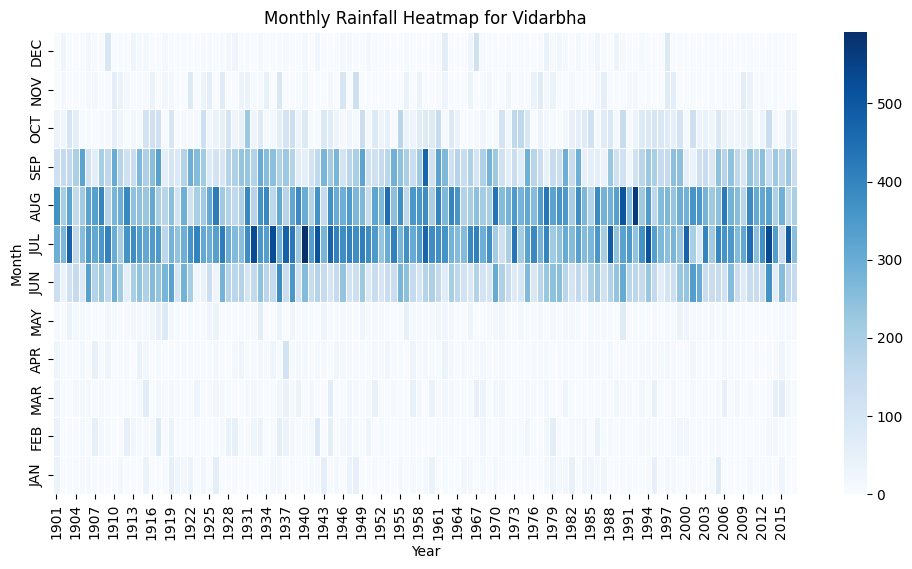

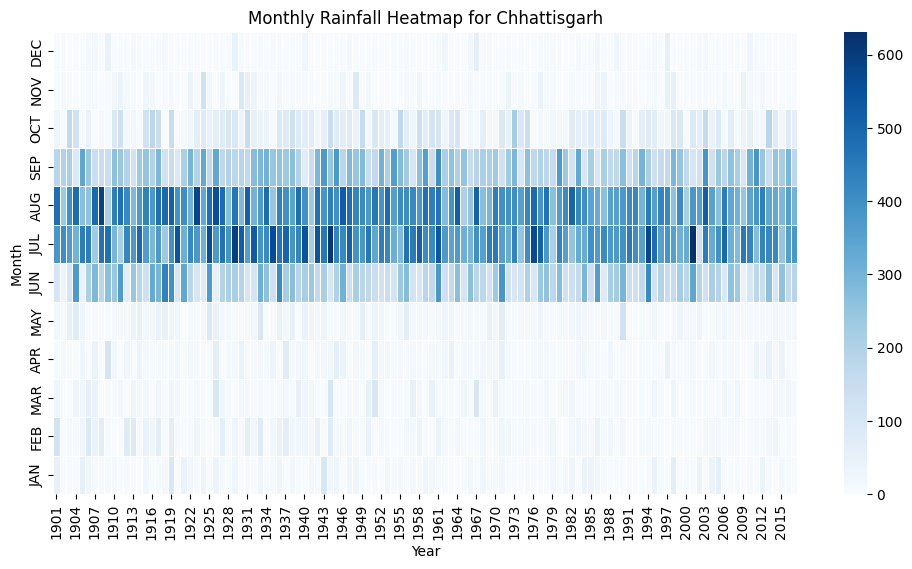

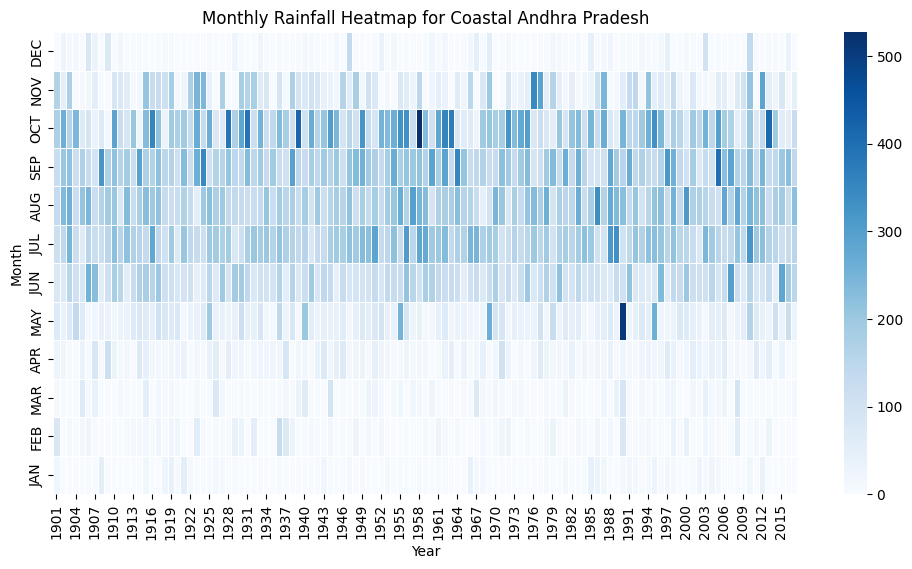

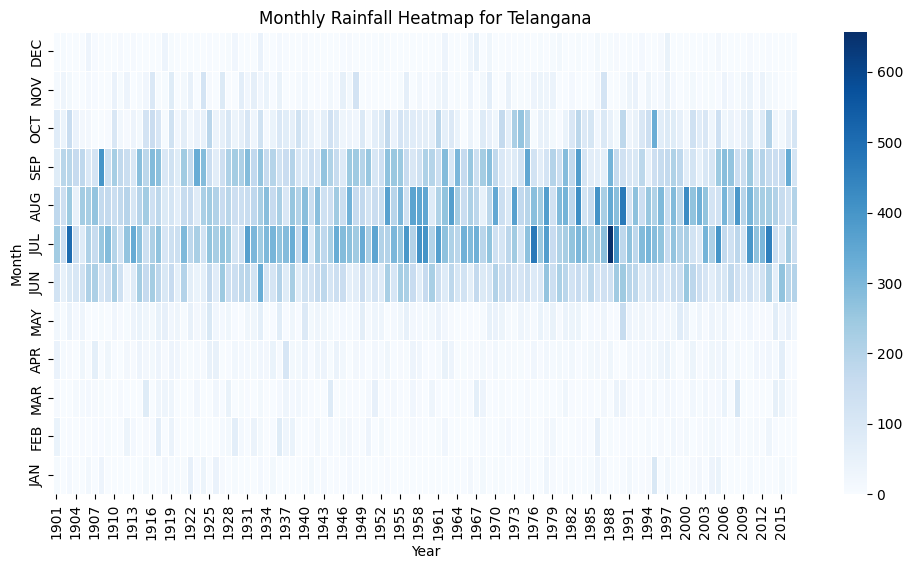

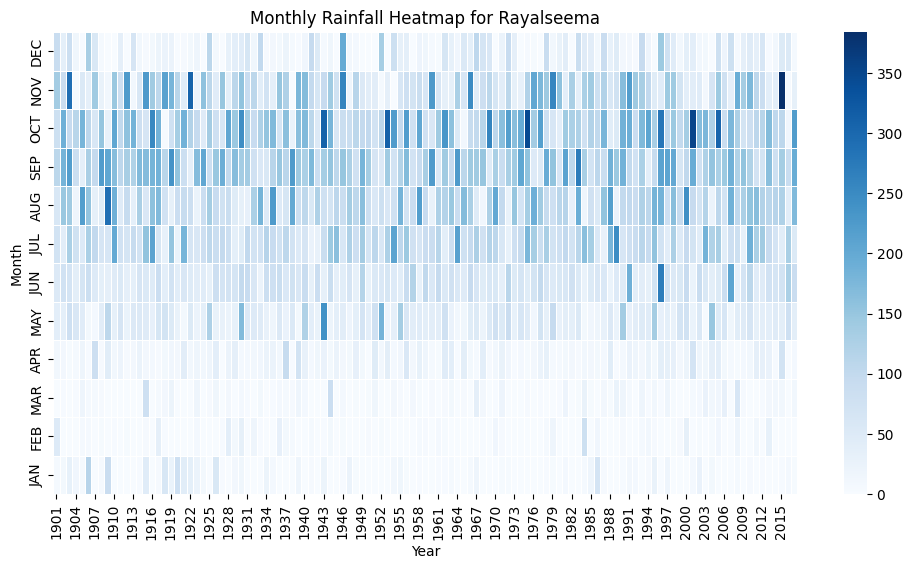

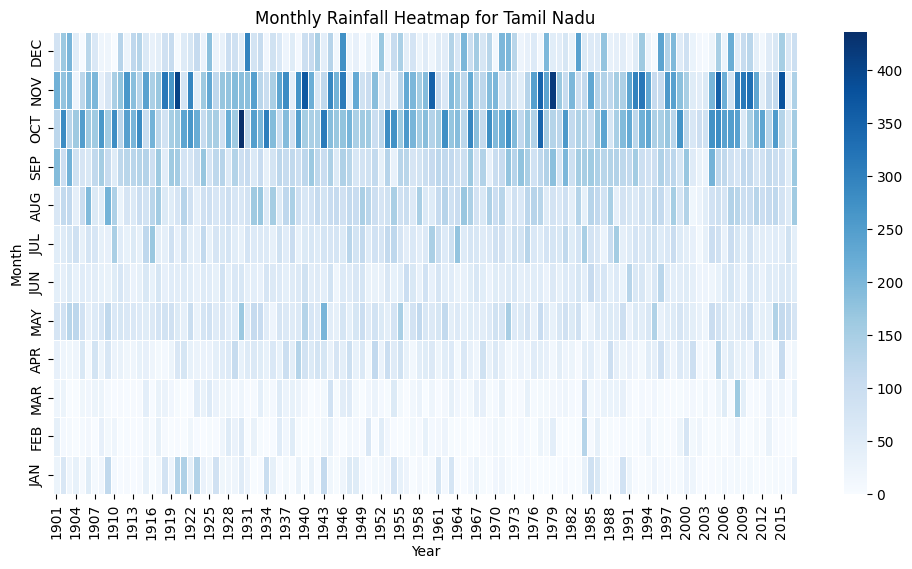

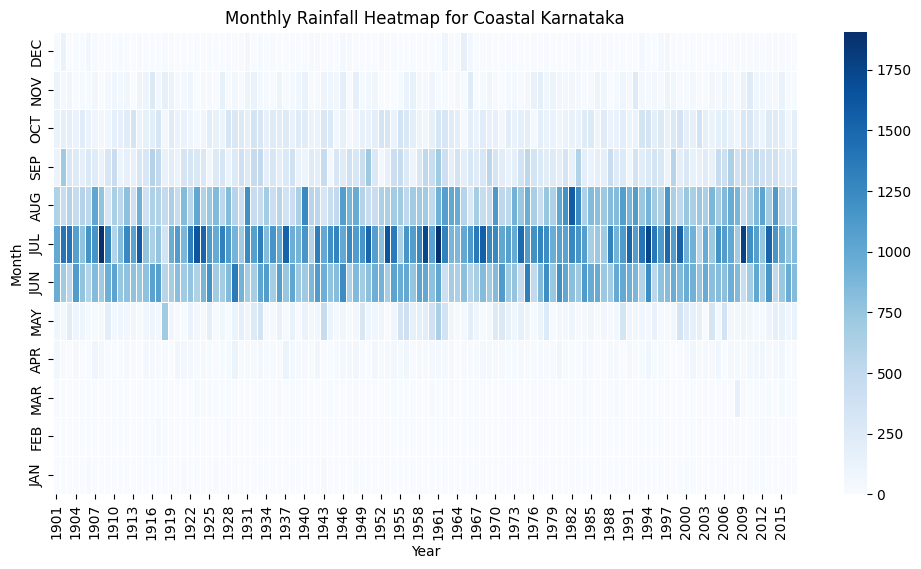

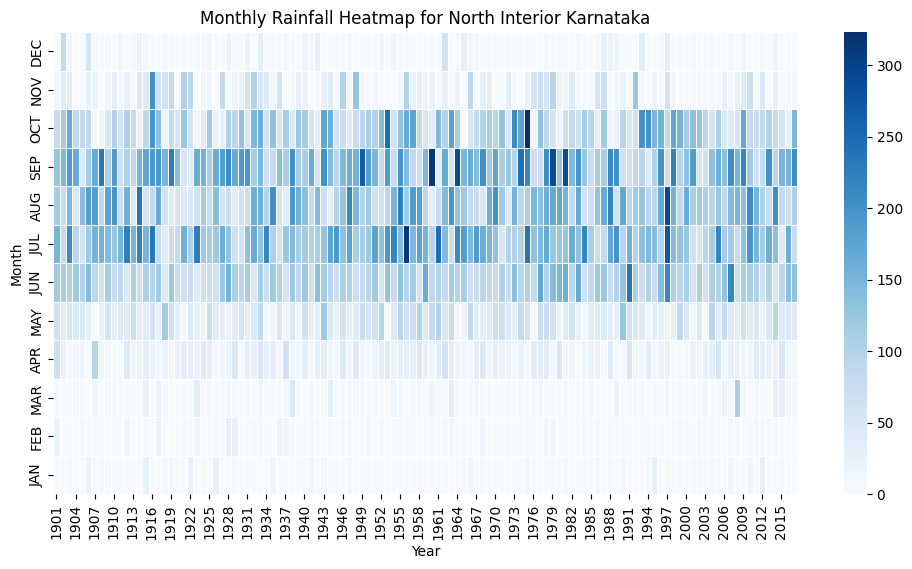

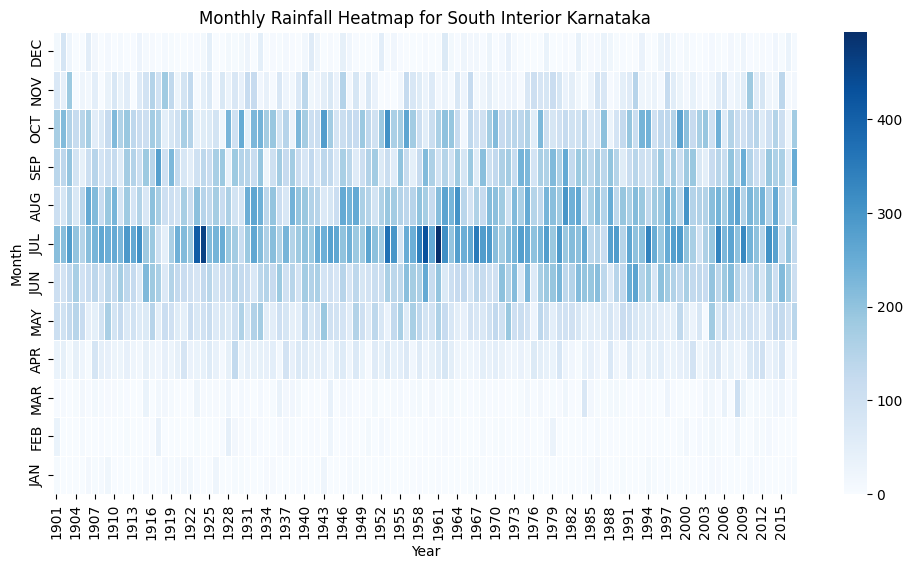

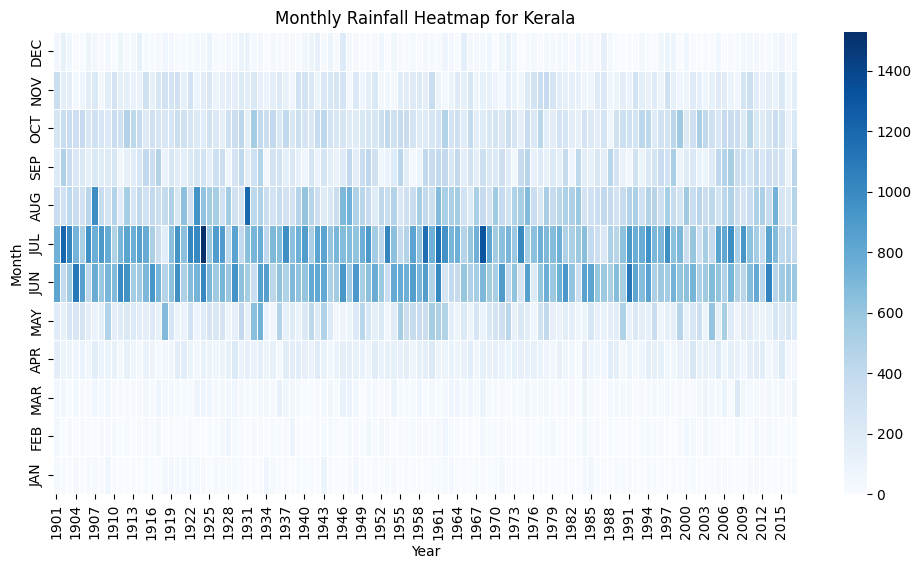

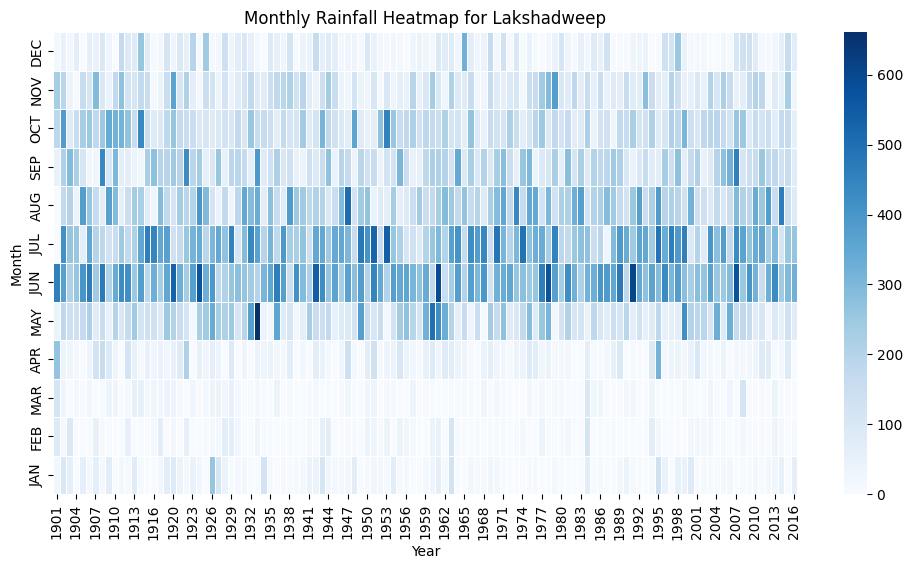

In [8]:
for state in df['SUBDIVISION'].unique():
    plot_rainfall_heatmap(df, state)

**Except for a few states ( Arunachal Pradesh and Naga mani mizo tripura)  there has not been much change in monthwise/season wise trends of rainfall. So given the state we might be able to make predictions.**

In [10]:
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

**We will determine the time series model for a particular state and use the same model for all states to make predictions.**

In [11]:
state_df = df[df['SUBDIVISION'] == 'Kerala']

# Define the correct month order
month_order = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
               'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

# Convert to long format
df_long = state_df.melt(id_vars=['YEAR'], value_vars=month_order, 
                         var_name='Month', value_name='Rainfall')

# Create a time index
df_long['Date'] = pd.to_datetime(df_long['YEAR'].astype(str) + '-' + df_long['Month'], format='%Y-%b')

# Sort by date
df_long = df_long.sort_values(by='Date')
df_long.set_index('Date', inplace=True)

# Drop unnecessary columns
df_long = df_long[['Rainfall']]

# Train-test split (train till 2014, test on 2015-2017)
train = df_long[df_long.index.year <= 2014]
test = df_long[df_long.index.year > 2014]

# ADF Test for Stationarity
result = adfuller(train['Rainfall'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -5.571590329050455
p-value: 1.4632932160515206e-06


**The small p-value indicates that the time series is stationary. We will now find seasonal trends**

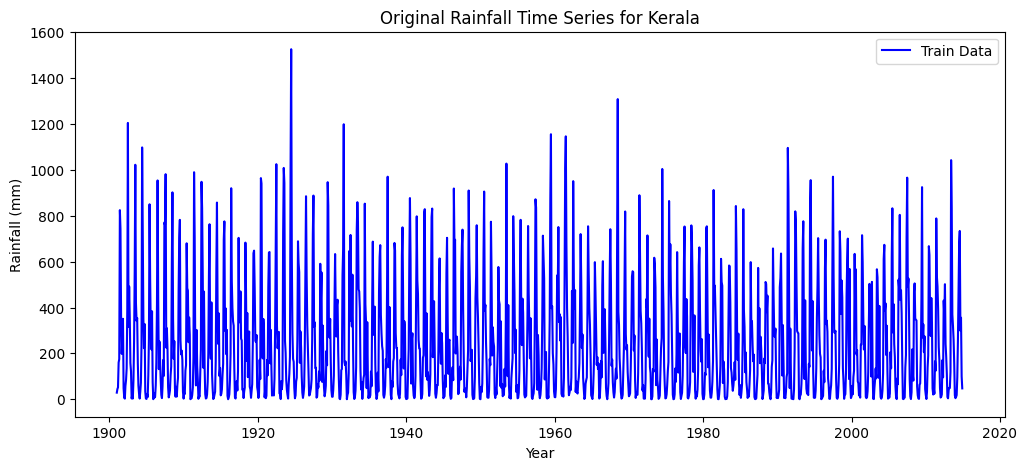

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Rainfall'], label='Train Data', color='blue')
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.title(f"Original Rainfall Time Series for Kerala")
plt.legend()
plt.show()

**Checking for seasonal trend.**

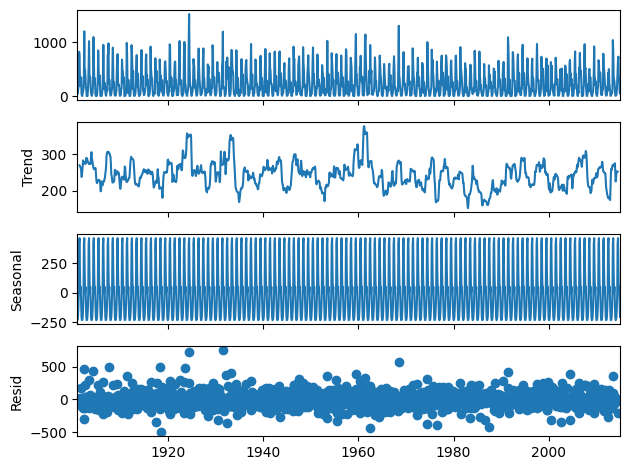

In [13]:
decomposition = sm.tsa.seasonal_decompose(train, period=12, model='additive')
decomposition.plot()
plt.show()

**There is some seasonal trend based on decomposition plot**

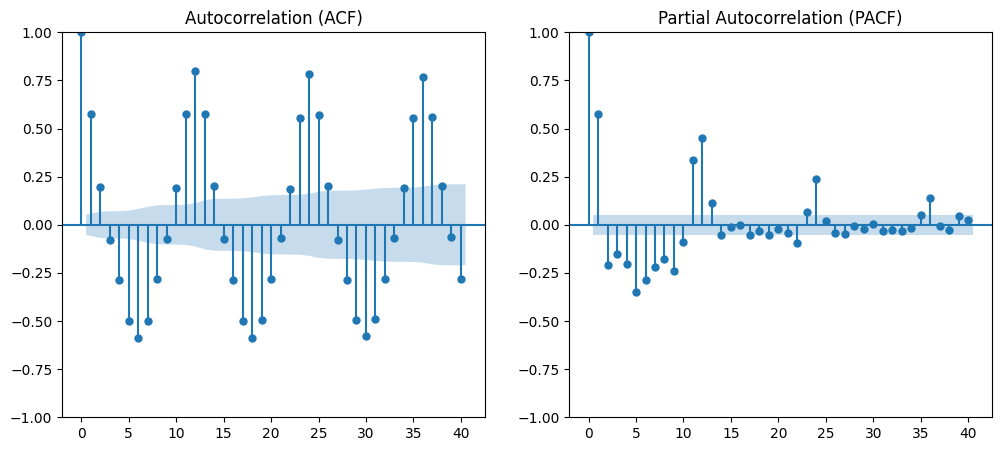

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(train['Rainfall'], lags=40, ax=axes[0])
plot_pacf(train['Rainfall'], lags=40, ax=axes[1])
axes[0].set_title("Autocorrelation (ACF)")
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.show()


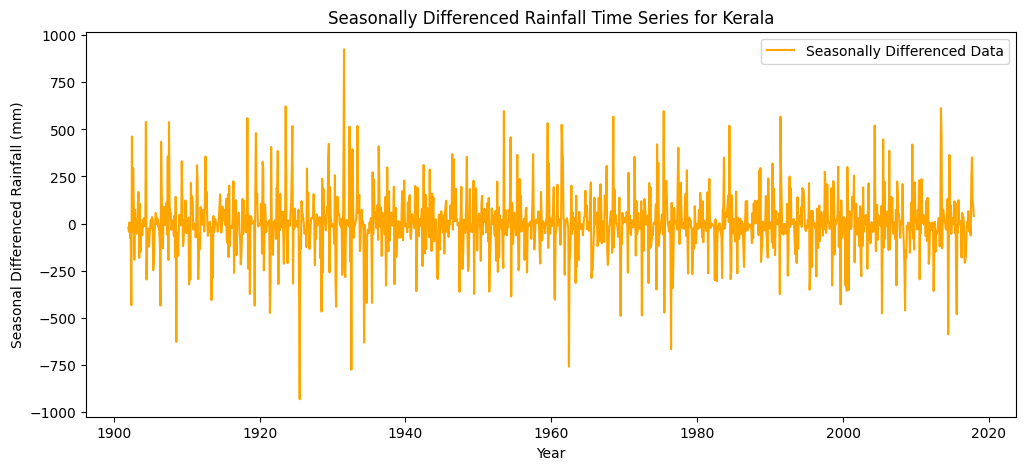

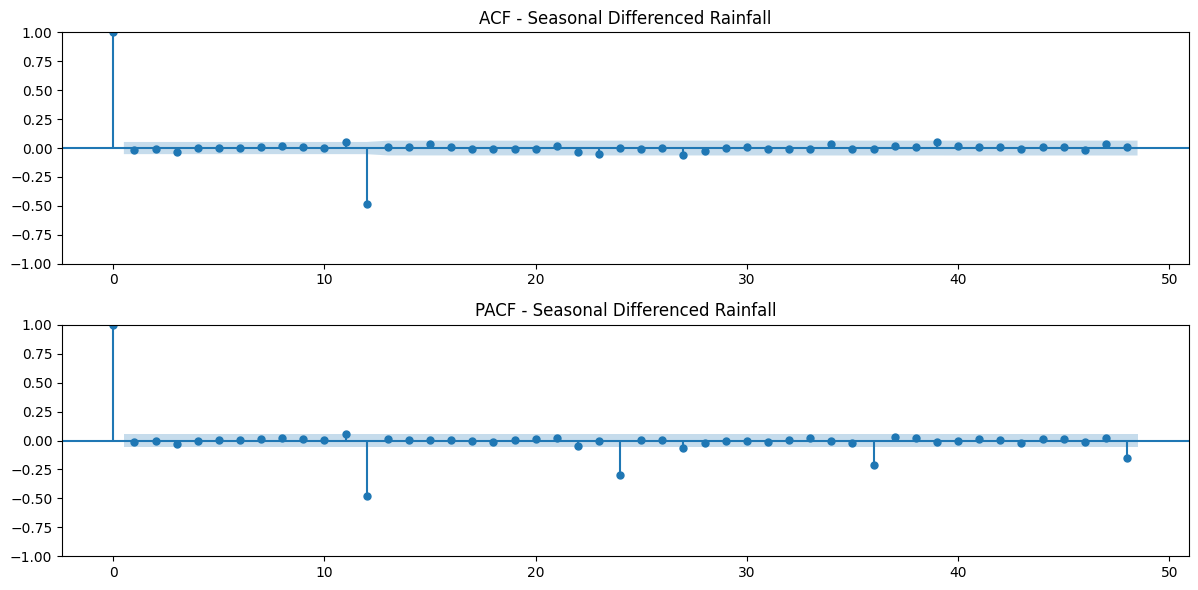

In [15]:

df_long['Seasonal_Diff'] = df_long['Rainfall'] - df_long['Rainfall'].shift(12)


plt.figure(figsize=(12, 5))
plt.plot(df_long.index, df_long['Seasonal_Diff'], label='Seasonally Differenced Data', color='orange')
plt.xlabel("Year")
plt.ylabel("Seasonal Differenced Rainfall (mm)")
plt.title(f"Seasonally Differenced Rainfall Time Series for Kerala")
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(211)
plot_acf(df_long['Seasonal_Diff'].dropna(), lags=48, ax=plt.gca())
plt.title("ACF - Seasonal Differenced Rainfall")


plt.subplot(212)
plot_pacf(df_long['Seasonal_Diff'].dropna(), lags=48, ax=plt.gca())
plt.title("PACF - Seasonal Differenced Rainfall")

plt.tight_layout()
plt.show()


**Based on the acf and pacf plots we will select SARIMA model (1,0,0) X (1,1,1,12)**

In [21]:
warnings.filterwarnings('ignore')

sarima_model = SARIMAX(train, order=(1,0,0), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = sarima_model.fit(disp=False)


forecast = model_fit.get_forecast(steps=len(test))
test['Predicted_Rainfall'] = forecast.predicted_mean



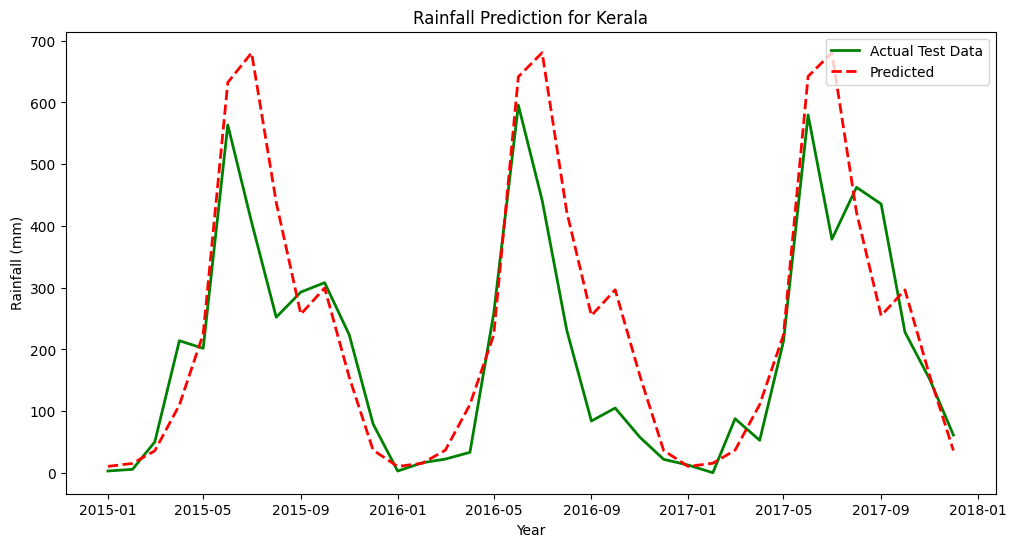

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Rainfall'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test.index, test['Predicted_Rainfall'], label='Predicted', color='red', linestyle='dashed', linewidth=2)


plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.title(f"Rainfall Prediction for Kerala")
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



mse = mean_squared_error(test['Rainfall'], test['Predicted_Rainfall'])


rmse = np.sqrt(mse)


r2 = r2_score(test['Rainfall'], test['Predicted_Rainfall'])


print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 112.4156901550488
R²: 0.610985662745047


**Now we will also explore spatial relations**

In [25]:
import folium
import pandas as pd
from folium.plugins import HeatMap


heat_data = df[['Latitude', 'Longitude', 'ANNUAL']].dropna().values.tolist()


m = folium.Map(location=[20, 80], zoom_start=5)


HeatMap(heat_data, radius=10).add_to(m)


m


**Theres is some level of spatial relations. some locations have significantly different amount of rainfail.**

Overall RMSE: 83.31
Overall R²: 0.71


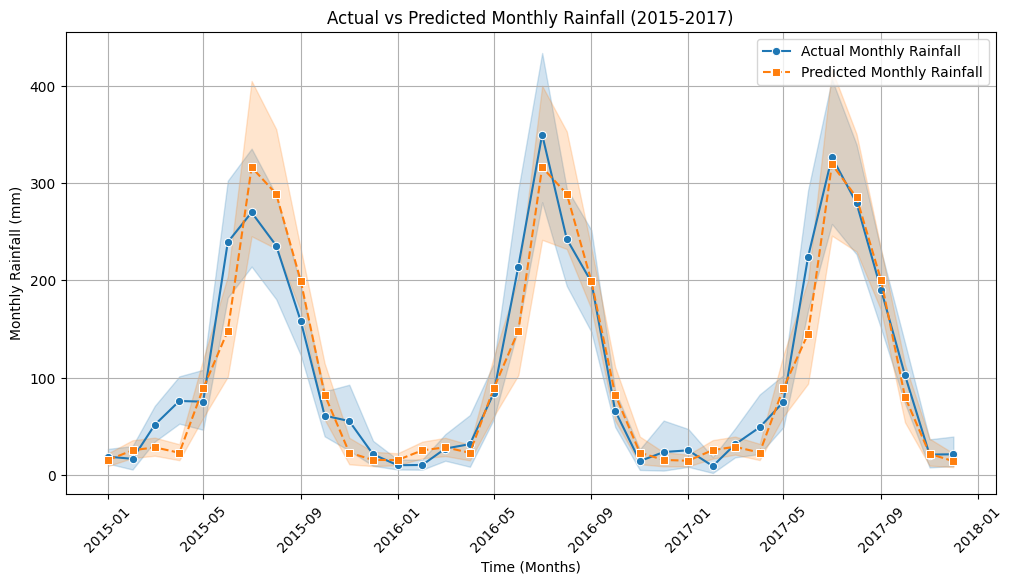

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score


monthly_columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
features = ['YEAR', 'Latitude', 'Longitude']


train_df = df[df["YEAR"] < 2015]
test_df = df[df["YEAR"].isin([2015, 2016, 2017])].copy()  # Copy to avoid SettingWithCopyWarning

predictions = {}


for month in monthly_columns:
    X_train, y_train = train_df[features], train_df[month]
    X_test, y_test = test_df[features], test_df[month]


    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    

    test_df[f'Predicted_{month}'] = model.predict(X_test)


actual_values = test_df[monthly_columns].values.flatten()
predicted_values = test_df[[f'Predicted_{month}' for month in monthly_columns]].values.flatten()


rmse_total = np.sqrt(mean_squared_error(actual_values, predicted_values))
r2_total = r2_score(actual_values, predicted_values)

print(f"Overall RMSE: {rmse_total:.2f}")
print(f"Overall R²: {r2_total:.2f}")


time_series_df = test_df[['YEAR']].copy()
time_series_df = time_series_df.loc[test_df.index.repeat(12)].reset_index(drop=True)
time_series_df['MONTH'] = np.tile(monthly_columns, len(test_df))
time_series_df['Actual_Rainfall'] = actual_values
time_series_df['Predicted_Rainfall'] = predicted_values


time_series_df['Date'] = pd.to_datetime(time_series_df['YEAR'].astype(str) + '-' + time_series_df['MONTH'], format='%Y-%b')


plt.figure(figsize=(12, 6))
sns.lineplot(data=time_series_df, x="Date", y="Actual_Rainfall", marker="o", label="Actual Monthly Rainfall")
sns.lineplot(data=time_series_df, x="Date", y="Predicted_Rainfall", marker="s", linestyle="dashed", label="Predicted Monthly Rainfall")

plt.xlabel("Time (Months)")
plt.ylabel("Monthly Rainfall (mm)")
plt.title("Actual vs Predicted Monthly Rainfall (2015-2017)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()



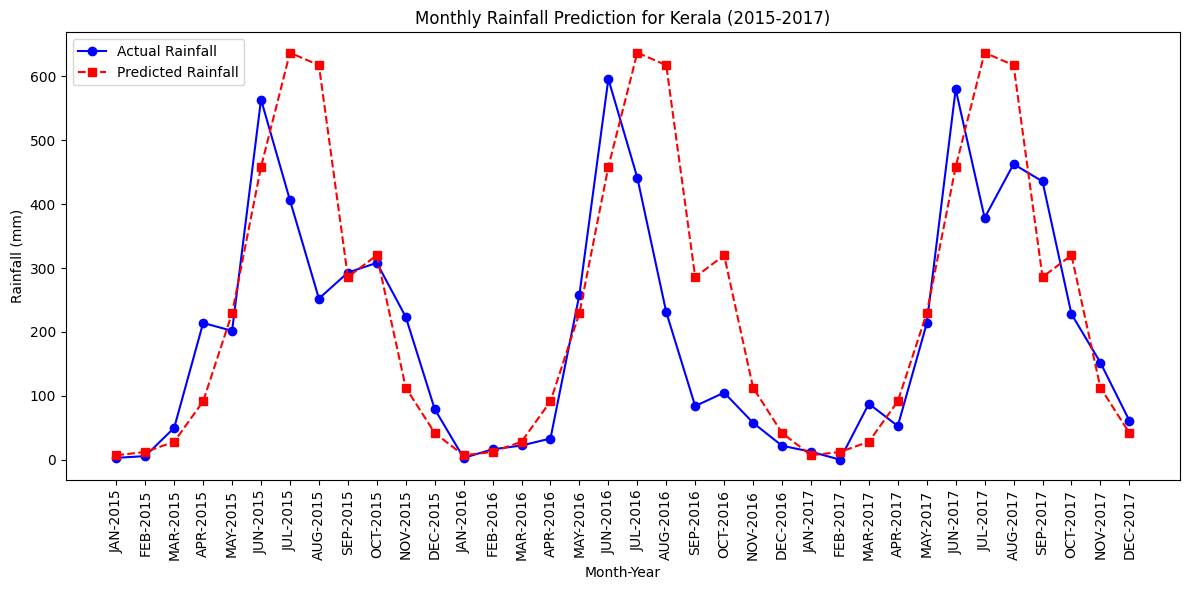

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


kerala_test_df = test_df[test_df["SUBDIVISION"] == "Kerala"].copy()
kerala_test_df = kerala_test_df.sort_values(by=["YEAR"])


months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
years = [2015, 2016, 2017]
x_labels = [f"{m}-{y}" for y in years for m in months]  # Create time series labels


actual_rainfall = kerala_test_df[months].values.flatten()  # Convert DataFrame to 1D array
predicted_rainfall = kerala_test_df[[f"Predicted_{m}" for m in months]].values.flatten()



plt.figure(figsize=(12, 6))
plt.plot(x_labels, actual_rainfall, marker="o", linestyle="-", label="Actual Rainfall", color="blue")
plt.plot(x_labels, predicted_rainfall, marker="s", linestyle="--", label="Predicted Rainfall", color="red")


plt.xticks(rotation=90)
plt.xlabel("Month-Year")
plt.ylabel("Rainfall (mm)")
plt.title(f"Monthly Rainfall Prediction for Kerala (2015-2017)")
plt.legend()
plt.tight_layout()


plt.show()


**Inlcuding the spatial information as features and using xgboost definitely makes the predictions better. Therefore recommended prediction model for this data would be an XGboost model with both spatiala and temporal features.**